# TIME SERIES FORECASTING TUTORIAL
## USING MACHINE LEARNING TO FORECAST ENERGY CONSUMPTION
Source: https://www.youtube.com/watch?v=vV12dGe_Fho

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [3]:
df = pd.read_csv('./data_raw/AEP_hourly.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None
              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0


In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB
None
             Datetime   AEP_MW
0 2004-12-31 01:00:00  13478.0
1 2004-12-31 02:00:00  12865.0
2 2004-12-31 03:00:00  12577.0
3 2004-12-31 04:00:00  12517.0
4 2004-12-31 05:00:00  12670.0


In [5]:
df = df.set_index('Datetime')

<AxesSubplot: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

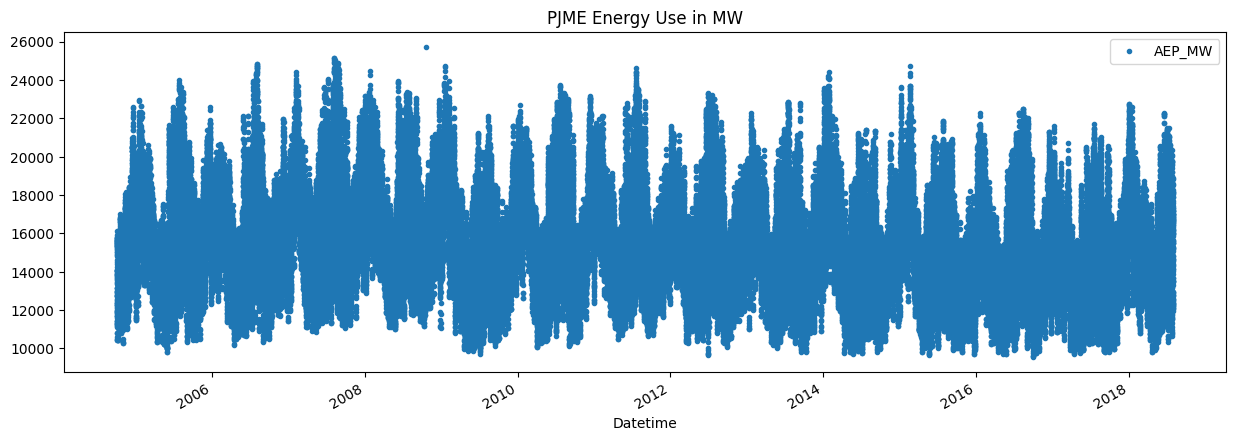

In [6]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME Energy Use in MW')

# Train/ Test Split

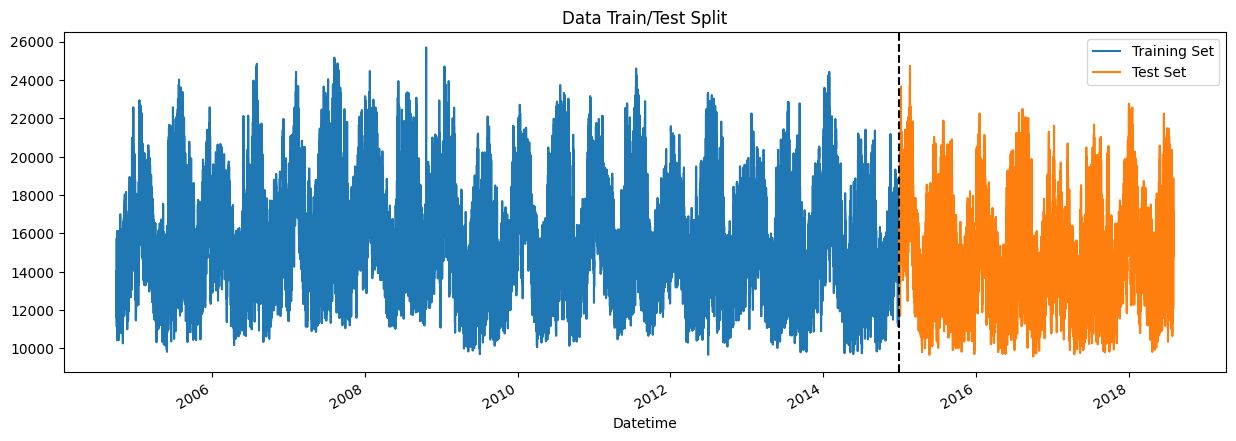

In [7]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [8]:
# df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week of Data')
# plt.show()

# Feature Creation

In [9]:
def create_features(df):
    """
    Create time series feature based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    return df

In [10]:
df = create_features(df)
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,is_month_start,is_month_end
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,0,1
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,0,1
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,0,1
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,0,1
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,0,1


# Visualize our Feature / Target Relationship

In [11]:
# fig, ax = plt.subplots(figsize=(10,8))
# sns.boxplot(data=df, x='hour', y='AEP_MW')
# ax.set_title('MW by Hour')
# plt.show()

In [12]:
# fig, ax = plt.subplots(figsize=(10,8))
# sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
# ax.set_title('MW by Month')
# plt.show()

# Create our Model

In [13]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'is_month_start', 'is_month_end']
TARGET = 'AEP_MW'

In [14]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
lgb_params = {'num_leaves':10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name= FEATURES)
lgbval = lgb.Dataset(data=X_test, label=y_test, reference=lgbtrain, feature_name= FEATURES)

In [16]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

/home/erica/Documents/energy_consumption/.env/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/erica/Documents/energy_consumption/.env/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/Documents/energy_consumption/.env/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 2.65347e+06	valid_1's l2: 3.53578e+06
[200]	training's l2: 1.95908e+06	valid_1's l2: 2.89117e+06
[300]	training's l2: 1.71984e+06	valid_1's l2: 2.70771e+06
[400]	training's l2: 1.59751e+06	valid_1's l2: 2.68994e+06
[500]	training's l2: 1.50038e+06	valid_1's l2: 2.67929e+06
[600]	training's l2: 1.41902e+06	valid_1's l2: 2.6588e+06
[700]	training's l2: 1.36748e+06	valid_1's l2: 2.64138e+06
[800]	training's l2: 1.32619e+06	valid_1's l2: 2.64801e+06
Early stopping, best iteration is:
[670]	training's l2: 1.3798e+06	valid_1's l2: 2.63795e+06


In [17]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Feature Importance

In [18]:
fi = pd.DataFrame(data = model.feature_importance(),
             index=model.feature_name(),
             columns=['Importance'])

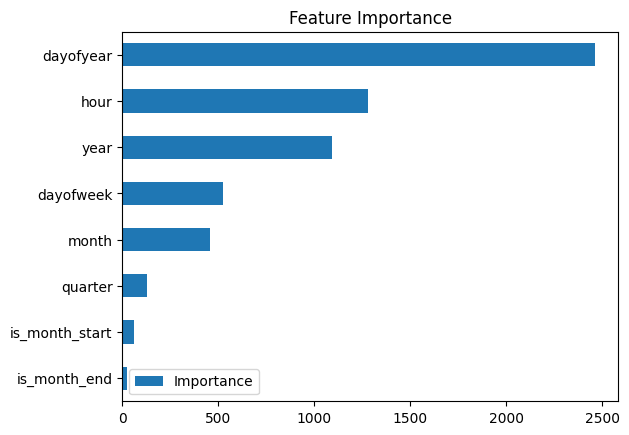

In [19]:
fi.sort_values('Importance').plot(kind ='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [20]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


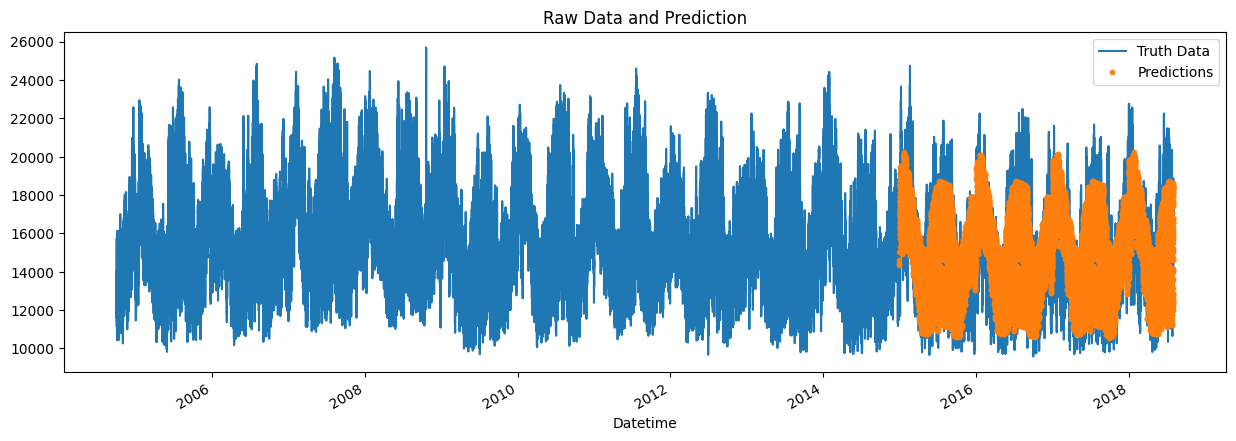

In [21]:
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

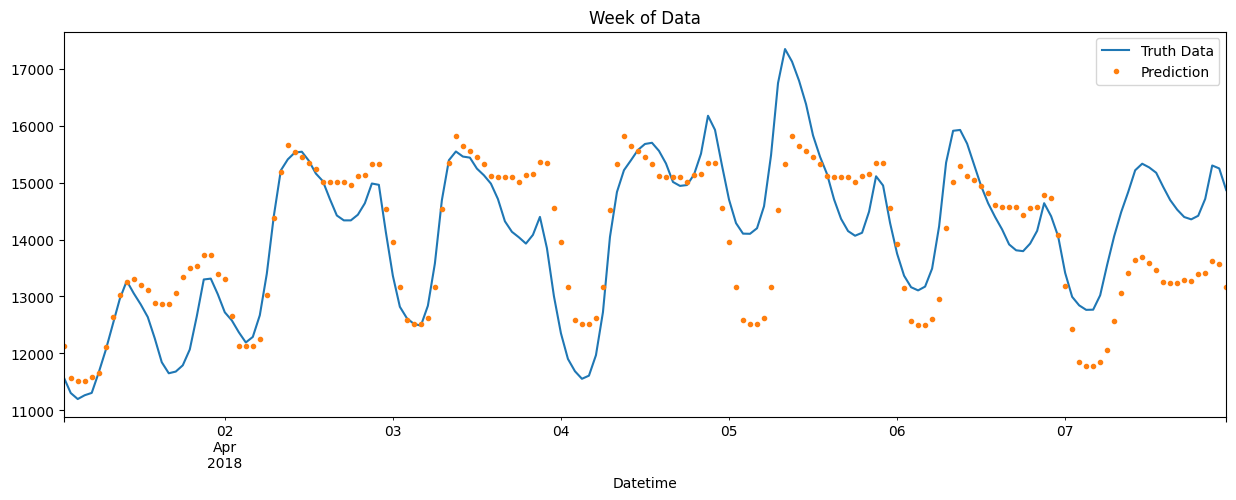

In [22]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15,5), title= 'Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

* There is a lot of improvement that we could make
* We could have a better hyperparameter tunning (we didn't tune this model) 
* Add features for specific days (e.g. hollidays)

In [23]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 1624.18


# Calculate Error
* Look at the worst and best predicted days

In [24]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [25]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2015-02-20    4897.850757
2015-02-19    4810.499248
2017-01-22    4659.358295
2017-01-21    4646.698652
2017-01-23    4431.442808
Name: error, dtype: float64

In [26]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2018-08-03    174.540323
2015-06-20    215.252086
2016-01-22    216.056340
2017-10-05    228.112327
2018-04-15    230.813797
Name: error, dtype: float64

# Next Steps
- More robust cross Validation
- Add more features (weather forecast, holidays)